### Unzip

In [1]:
import zipfile
import os

def extract_zip_file(zip_file_path, dest_path):
    # Ensure the destination path exists
    if not os.path.exists(dest_path):
        os.makedirs(dest_path)

    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(dest_path)
        

# Use the function
zip_file_path = '../archive.zip'  # replace with your zip file path
dest_path = os.getcwd()  # get current working directory
extract_zip_file(zip_file_path, dest_path)

### Data

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

attr = pd.read_csv('list_attr_celeba.csv')
features = ['image_id', 'Attractive', 'Bangs', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair', 'Male', 'Oval_Face', 'Receding_Hairline', 'Smiling']

attr_selected = attr.loc[:, features].iloc[:50000,:]
attr_selected = attr_selected.replace(-1,0)
attr_selected

2023-05-27 21:08:07.452203: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-27 21:08:07.477905: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-27 21:08:07.880495: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


,image_id,Attractive,Bangs,Black_Hair,Blond_Hair,Brown_Hair,Gray_Hair,Male,Oval_Face,Receding_Hairline,Smiling
0,000001.jpg,1,0,0,0,1,0,0,0,0,1
1,000002.jpg,0,0,0,0,1,0,0,0,0,1
2,000003.jpg,0,0,0,0,0,0,1,0,0,0
3,000004.jpg,1,0,0,0,0,0,0,0,0,0
4,000005.jpg,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
49995,049996.jpg,0,0,0,1,0,0,0,1,0,1
49996,049997.jpg,1,1,0,0,1,0,0,0,0,1
49997,049998.jpg,0,0,1,0,0,0,1,0,0,0
49998,049999.jpg,1,0,0,0,0,0,0,0,0,1


In [4]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(attr_selected, test_size=0.1)
train_df, val_df = train_test_split(train_df, test_size=0.2)

In [5]:
features = ['Attractive', 'Bangs', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair', 'Male', 'Oval_Face', 'Receding_Hairline', 'Smiling']
for feature in features:
    train_df[feature] = train_df[feature].astype('float32')
    val_df[feature] = val_df[feature].astype('float32')
    test_df[feature] = test_df[feature].astype('float32')

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split

batch_size = 64
img_height = 128
img_width = 128

# Create ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, zoom_range=0.2, shear_range=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(train_df, directory="img_align_celeba/img_align_celeba", 
                                                    x_col="image_id", y_col=features,
                                                    target_size=(img_height, img_width), 
                                                    batch_size=batch_size, class_mode='raw')

val_generator = train_datagen.flow_from_dataframe(val_df, directory="img_align_celeba/img_align_celeba", 
                                                    x_col="image_id", y_col=features,
                                                    target_size=(img_height, img_width), 
                                                    batch_size=batch_size, class_mode='raw')

test_generator = test_datagen.flow_from_dataframe(test_df, directory="img_align_celeba/img_align_celeba", 
                                                  x_col="image_id", y_col=features, 
                                                  target_size=(img_height, img_width), 
                                                  batch_size=batch_size, class_mode='raw', shuffle=False)



Found 36000 validated image filenames.
Found 9000 validated image filenames.
Found 5000 validated image filenames.


### Distribute load

In [ ]:
# Distribute load over all GPU

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split

def set_gpus(*gpu_indices):
    # Get list of GPUs
    gpus = tf.config.experimental.list_physical_devices('GPU')
    print("Num GPUs Available: ", len(gpus))

    if gpus:
        visible_gpus = [gpus[i] for i in gpu_indices]
        try:
            # Only use specified GPUs and ignore the others
            tf.config.experimental.set_visible_devices(visible_gpus, 'GPU')
            for gpu in visible_gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("Using GPUs: ", [gpu.name for gpu in visible_gpus])
        except RuntimeError as e:
            print(e)
    return visible_gpus

# Call the function with the indices of the GPUs you want to use
visible_gpus = set_gpus(0, 1, 2, 3, 4)  # Use the second, third, fourth, and fifth GPU

# Extract names of the GPUs being used
gpu_names = ['/device:GPU:' + gpu.name.split(':')[-1] for gpu in visible_gpus]

strategy = tf.distribute.MirroredStrategy(devices=gpu_names)

Num GPUs Available:  5
Using GPUs:  ['/physical_device:GPU:0', '/physical_device:GPU:1', '/physical_device:GPU:2', '/physical_device:GPU:3', '/physical_device:GPU:4']
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4')


In [9]:
# Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1_l2

def _create_model(input_shape):
    model = Sequential([
        Conv2D(32, (3,3), activation = 'relu', input_shape = (input_shape[0], input_shape[1], 3), kernel_regularizer = l1_l2(l1=1e-5, l2=1e-4)),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.25),

        Conv2D(64, (3,3), activation = 'relu', kernel_regularizer = l1_l2(l1=1e-5, l2=1e-4)),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.25),

        Conv2D(128, (3,3), activation = 'relu', kernel_regularizer = l1_l2(l1=1e-5, l2=1e-4)),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.25),

        Conv2D(256, (3,3), activation = 'relu', kernel_regularizer = l1_l2(l1=1e-5, l2=1e-4)),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.25),

        Conv2D(512, (3,3), activation = 'relu', kernel_regularizer = l1_l2(l1=1e-5, l2=1e-4)),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.25),

        Flatten(),
        Dense(2048, activation = 'relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(len(features), activation='sigmoid')

    ])

    return model

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# with strategy.scope():
m1 = _create_model((img_height, img_width))
m1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
history = m1.fit(train_generator, epochs = 100, validation_data = val_generator, callbacks = [callback])

Epoch 1/100


2023-05-25 23:42:55.857544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-25 23:42:56.558053: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


563/563 [==============================] - ETA: 0s - loss: 0.6941 - accuracy: 0.3344

2023-05-25 23:43:48.505959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


563/563 [==============================] - 65s 112ms/step - loss: 0.6941 - accuracy: 0.3344 - val_loss: 0.6497 - val_accuracy: 0.3112
Epoch 2/100
563/563 [==============================] - 62s 110ms/step - loss: 0.4850 - accuracy: 0.3371 - val_loss: 0.4368 - val_accuracy: 0.3448
Epoch 3/100
563/563 [==============================] - 62s 109ms/step - loss: 0.4256 - accuracy: 0.3396 - val_loss: 0.4198 - val_accuracy: 0.3772
Epoch 4/100
563/563 [==============================] - 62s 110ms/step - loss: 0.4098 - accuracy: 0.3382 - val_loss: 0.4027 - val_accuracy: 0.3504
Epoch 5/100
563/563 [==============================] - 63s 112ms/step - loss: 0.4023 - accuracy: 0.3352 - val_loss: 0.4170 - val_accuracy: 0.3504
Epoch 6/100
563/563 [==============================] - 62s 110ms/step - loss: 0.4010 - accuracy: 0.3416 - val_loss: 0.4070 - val_accuracy: 0.3479
Epoch 7/100
563/563 [==============================] - 62s 109ms/step - loss: 0.3984 - accuracy: 0.3414 - val_loss: 0.3910 - val_accurac

In [13]:
loss, accuracy = m1.evaluate(test_generator, steps=len(test_generator), verbose=0)
print(f'Test loss for the model : {loss:.4f}')
print(f'Test accuracy for the model: {accuracy:.4f}')

2023-05-26 04:21:44.079585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Test loss for the model : 0.3209
Test accuracy for the model: 0.2836


### Try random search for hyperparameter tuning

In [12]:
from keras import optimizers
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch

batch_size = 64
img_height = 128
img_width = 128

class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = Sequential()
        use_bn = hp.Boolean('use_batch_norm')
        model.add(Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
                         kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
                         activation='relu',
                         input_shape=self.input_shape))
        model.add(MaxPooling2D((2, 2)))
        if use_bn:
            model.add(BatchNormalization())
        model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))

        model.add(Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=256, step=16),
                         kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
                         activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        if use_bn:
            model.add(BatchNormalization())
        model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))

        model.add(Conv2D(filters=hp.Int('conv_3_filter', min_value=32, max_value=512, step=16),
                         kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),
                         activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        if use_bn:
            model.add(BatchNormalization())
        model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))

        model.add(Conv2D(filters=hp.Int('conv_4_filter', min_value=32, max_value=1024, step=16),
                         kernel_size=hp.Choice('conv_4_kernel', values = [3,5]),
                         activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        if use_bn:
            model.add(BatchNormalization())
        model.add(Dropout(rate=hp.Float('dropout_4', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))

        model.add(Flatten())
        model.add(Dense(units=hp.Int('dense_1_units', min_value=32, max_value=2048, step=16),
                        activation='relu'))
        if use_bn:
            model.add(BatchNormalization())
        model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))

        model.add(Dense(self.num_classes, activation='sigmoid'))

        model.compile(optimizer=optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        return model

input_shape = (img_height, img_width, 3)  # Assuming your images are RGB, adjust if otherwise
num_classes = len(features)

hypermodel = CNNHyperModel(input_shape, num_classes)

tuner = RandomSearch(hypermodel,
                     objective='val_accuracy',
                     max_trials=5,
                     executions_per_trial=3,
                     directory='random_search',
                     project_name='cnn_hyperparam_tuning')

tuner.search_space_summary()

tuner.search(train_generator, 
             epochs=10, 
             validation_data=val_generator,
             steps_per_epoch=train_generator.samples // batch_size,  # Required due to use of generator
             validation_steps=val_generator.samples // batch_size)  # Required due to use of generator

tuner.results_summary()


Trial 5 Complete [00h 42m 44s]
val_accuracy: 0.4107142786184947

Best val_accuracy So Far: 0.4969865878423055
Total elapsed time: 03h 08m 52s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in random_search/cnn_hyperparam_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 1 summary
Hyperparameters:
use_batch_norm: False
conv_1_filter: 80
conv_1_kernel: 5
dropout_1: 0.15000000000000002
conv_2_filter: 240
conv_2_kernel: 3
dropout_2: 0.25
conv_3_filter: 464
conv_3_kernel: 5
dropout_3: 0.05
conv_4_filter: 1024
conv_4_kernel: 5
dropout_4: 0.35000000000000003
dense_1_units: 48
learning_rate: 0.009249561789910456
Score: 0.4969865878423055

Trial 0 summary
Hyperparameters:
use_batch_norm: True
conv_1_filter: 96
conv_1_kernel: 5
dropout_1: 0.35000000000000003
conv_2_filter: 208
conv_2_kernel: 3
dropout_2: 0.05
conv_3_filter: 304
conv_3_kernel: 5
dropout_3: 0.0
conv_4_filter: 464
conv_4_kernel: 3
dropout_4: 0.30000000000000004
dense_1_units: 464
le

In [14]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 80)      6080      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 80)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 62, 62, 80)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 240)       173040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 240)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 30, 30, 240)       0

In [15]:
loss, accuracy = best_model.evaluate(test_generator, steps=len(test_generator), verbose=0)
print(f'Test loss for the model : {loss:.4f}')
print(f'Test accuracy for the model: {accuracy:.4f}')

2023-05-26 12:44:07.895210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Test loss for the model : 0.5017
Test accuracy for the model: 0.5462


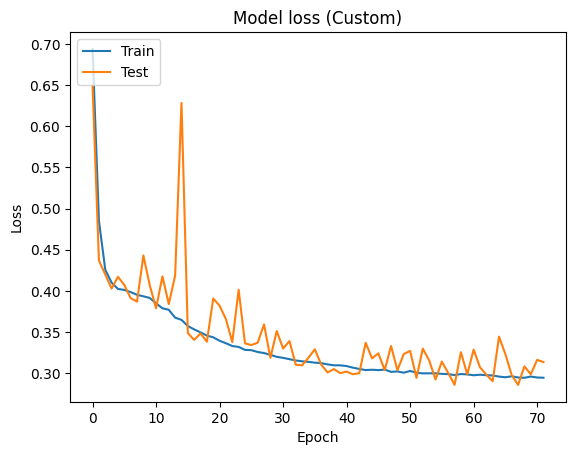

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss (Custom)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [18]:
best_model.save('custom_model_4_blocks_best.h5')

## 1 feature

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np

attr = pd.read_csv('list_attr_celeba.csv')
features = ['image_id', 'Attractive', 'Bangs', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair', 'Male', 'Oval_Face', 'Receding_Hairline', 'Smiling']

attr_selected = attr.loc[:, features].iloc[:50000,:]
attr_selected = attr_selected.replace(-1,0)
attr_selected

2023-05-27 21:20:44.517670: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-27 21:20:44.542321: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-27 21:20:44.915147: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


,image_id,Attractive,Bangs,Black_Hair,Blond_Hair,Brown_Hair,Gray_Hair,Male,Oval_Face,Receding_Hairline,Smiling
0,000001.jpg,1,0,0,0,1,0,0,0,0,1
1,000002.jpg,0,0,0,0,1,0,0,0,0,1
2,000003.jpg,0,0,0,0,0,0,1,0,0,0
3,000004.jpg,1,0,0,0,0,0,0,0,0,0
4,000005.jpg,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
49995,049996.jpg,0,0,0,1,0,0,0,1,0,1
49996,049997.jpg,1,1,0,0,1,0,0,0,0,1
49997,049998.jpg,0,0,1,0,0,0,1,0,0,0
49998,049999.jpg,1,0,0,0,0,0,0,0,0,1


In [11]:
from sklearn.model_selection import train_test_split

features = ['image_id', 'Attractive']

attr_selected = attr.loc[:, features].iloc[:50000,:]
attr_selected = attr_selected.replace(-1,0)

features = ['Attractive']

train_df, test_df = train_test_split(attr_selected, test_size=0.1)
train_df, val_df = train_test_split(train_df, test_size=0.2)

for feature in features:
    train_df[feature] = train_df[feature].astype('float32')
    val_df[feature] = val_df[feature].astype('float32')
    test_df[feature] = test_df[feature].astype('float32')

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Create ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, zoom_range=0.2, shear_range=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 64
img_height = 128
img_width = 128

train_generator = train_datagen.flow_from_dataframe(train_df, directory="img_align_celeba/img_align_celeba", 
                                                    x_col="image_id", y_col=features,
                                                    target_size=(img_height, img_width), 
                                                    batch_size=batch_size, class_mode='raw')

val_generator = train_datagen.flow_from_dataframe(val_df, directory="img_align_celeba/img_align_celeba", 
                                                    x_col="image_id", y_col=features,
                                                    target_size=(img_height, img_width), 
                                                    batch_size=batch_size, class_mode='raw')

test_generator = test_datagen.flow_from_dataframe(test_df, directory="img_align_celeba/img_align_celeba", 
                                                  x_col="image_id", y_col=features, 
                                                  target_size=(img_height, img_width), 
                                                  batch_size=batch_size, class_mode='raw', shuffle=False)

Found 36000 validated image filenames.
Found 9000 validated image filenames.
Found 5000 validated image filenames.


In [14]:
from keras import optimizers
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1_l2

batch_size = 64
img_height = 128
img_width = 128

class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = Sequential()
        use_bn = hp.Boolean('use_batch_norm')
        model.add(Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
                         kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
                         activation='relu',
                         input_shape=self.input_shape))
        model.add(MaxPooling2D((2, 2)))
        if use_bn:
            model.add(BatchNormalization())
        model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))

        model.add(Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=256, step=16),
                         kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
                         activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        if use_bn:
            model.add(BatchNormalization())
        model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))

        model.add(Conv2D(filters=hp.Int('conv_3_filter', min_value=32, max_value=512, step=16),
                         kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),
                         activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        if use_bn:
            model.add(BatchNormalization())
        model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))

        model.add(Conv2D(filters=hp.Int('conv_4_filter', min_value=32, max_value=1024, step=16),
                         kernel_size=hp.Choice('conv_4_kernel', values = [3,5]),
                         activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        if use_bn:
            model.add(BatchNormalization())
        model.add(Dropout(rate=hp.Float('dropout_4', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))

        model.add(Flatten())
        model.add(Dense(units=hp.Int('dense_1_units', min_value=32, max_value=2048, step=16),
                        activation='relu'))
        if use_bn:
            model.add(BatchNormalization())
        model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
        print(self.num_classes)
        model.add(Dense(self.num_classes, activation='sigmoid'))

        model.compile(optimizer=optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        return model

input_shape = (img_height, img_width, 3)  # Assuming your images are RGB, adjust if otherwise
num_classes = len(features)

hypermodel = CNNHyperModel(input_shape, num_classes)

tuner = RandomSearch(hypermodel,
                     objective='val_accuracy',
                     max_trials=5,
                     executions_per_trial=3,
                     directory='random_search_attractive',
                     project_name='cnn_hyperparam_tuning')

tuner.search_space_summary()

tuner.search(train_generator, 
             epochs=10, 
             validation_data=val_generator,
             steps_per_epoch=train_generator.samples // batch_size,  # Required due to use of generator
             validation_steps=val_generator.samples // batch_size)  # Required due to use of generator

tuner.results_summary()

Trial 5 Complete [01h 06m 15s]
val_accuracy: 0.7869419654210409

Best val_accuracy So Far: 0.7895461320877075
Total elapsed time: 03h 25m 04s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in random_search_attractive/cnn_hyperparam_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 2 summary
Hyperparameters:
use_batch_norm: True
conv_1_filter: 48
conv_1_kernel: 5
dropout_1: 0.15000000000000002
conv_2_filter: 80
conv_2_kernel: 3
dropout_2: 0.45
conv_3_filter: 208
conv_3_kernel: 3
dropout_3: 0.15000000000000002
conv_4_filter: 160
conv_4_kernel: 5
dropout_4: 0.0
dense_1_units: 1472
learning_rate: 0.004762726870866379
Score: 0.7895461320877075

Trial 4 summary
Hyperparameters:
use_batch_norm: True
conv_1_filter: 80
conv_1_kernel: 3
dropout_1: 0.25
conv_2_filter: 240
conv_2_kernel: 3
dropout_2: 0.25
conv_3_filter: 304
conv_3_kernel: 3
dropout_3: 0.45
conv_4_filter: 832
conv_4_kernel: 5
dropout_4: 0.0
dense_1_units: 1824
learning_rate: 0.00710

In [15]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 48)      3648      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 48)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 48)       192       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 62, 62, 48)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 80)        34640     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 80)      

In [16]:
loss, accuracy = best_model.evaluate(test_generator, steps=len(test_generator), verbose=0)
print(f'Test loss for the model : {loss:.4f}')
print(f'Test accuracy for the model: {accuracy:.4f}')

2023-05-28 00:51:29.002033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Test loss for the model : 0.4225
Test accuracy for the model: 0.7978


In [22]:
best_model.save("best_model_attractive.h5")

## Custom model Bangs

In [17]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

attr = pd.read_csv('list_attr_celeba.csv')
features = ['image_id', 'Bangs']

attr_selected = attr.loc[:, features].iloc[:50000,:]
attr_selected = attr_selected.replace(-1,0)

features = ['Bangs']

train_df, test_df = train_test_split(attr_selected, test_size=0.1)
train_df, val_df = train_test_split(train_df, test_size=0.2)

for feature in features:
    train_df[feature] = train_df[feature].astype('float32')
    val_df[feature] = val_df[feature].astype('float32')
    test_df[feature] = test_df[feature].astype('float32')

In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Create ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, zoom_range=0.2, shear_range=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 64
img_height = 128
img_width = 128

train_generator = train_datagen.flow_from_dataframe(train_df, directory="img_align_celeba/img_align_celeba", 
                                                    x_col="image_id", y_col=features,
                                                    target_size=(img_height, img_width), 
                                                    batch_size=batch_size, class_mode='raw')

val_generator = train_datagen.flow_from_dataframe(val_df, directory="img_align_celeba/img_align_celeba", 
                                                    x_col="image_id", y_col=features,
                                                    target_size=(img_height, img_width), 
                                                    batch_size=batch_size, class_mode='raw')

test_generator = test_datagen.flow_from_dataframe(test_df, directory="img_align_celeba/img_align_celeba", 
                                                  x_col="image_id", y_col=features, 
                                                  target_size=(img_height, img_width), 
                                                  batch_size=batch_size, class_mode='raw', shuffle=False)

Found 36000 validated image filenames.
Found 9000 validated image filenames.
Found 5000 validated image filenames.


In [19]:
from keras import optimizers
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1_l2

batch_size = 64
img_height = 128
img_width = 128

class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = Sequential()
        use_bn = hp.Boolean('use_batch_norm')
        model.add(Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
                         kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
                         activation='relu',
                         input_shape=self.input_shape))
        model.add(MaxPooling2D((2, 2)))
        if use_bn:
            model.add(BatchNormalization())
        model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))

        model.add(Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=256, step=16),
                         kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
                         activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        if use_bn:
            model.add(BatchNormalization())
        model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))

        model.add(Conv2D(filters=hp.Int('conv_3_filter', min_value=32, max_value=512, step=16),
                         kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),
                         activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        if use_bn:
            model.add(BatchNormalization())
        model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))

        model.add(Conv2D(filters=hp.Int('conv_4_filter', min_value=32, max_value=1024, step=16),
                         kernel_size=hp.Choice('conv_4_kernel', values = [3,5]),
                         activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        if use_bn:
            model.add(BatchNormalization())
        model.add(Dropout(rate=hp.Float('dropout_4', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))

        model.add(Flatten())
        model.add(Dense(units=hp.Int('dense_1_units', min_value=32, max_value=2048, step=16),
                        activation='relu'))
        if use_bn:
            model.add(BatchNormalization())
        model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
        print(self.num_classes)
        model.add(Dense(self.num_classes, activation='sigmoid'))

        model.compile(optimizer=optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        return model

input_shape = (img_height, img_width, 3)  # Assuming your images are RGB, adjust if otherwise
num_classes = len(features)

hypermodel = CNNHyperModel(input_shape, num_classes)

tuner_bangs = RandomSearch(hypermodel,
                     objective='val_accuracy',
                     max_trials=5,
                     executions_per_trial=3,
                     directory='random_search_bangs',
                     project_name='cnn_hyperparam_tuning')

tuner_bangs.search_space_summary()

tuner_bangs.search(train_generator, 
             epochs=10, 
             validation_data=val_generator,
             steps_per_epoch=train_generator.samples // batch_size,  # Required due to use of generator
             validation_steps=val_generator.samples // batch_size)  # Required due to use of generator

tuner_bangs.results_summary()

Trial 5 Complete [00h 30m 08s]
val_accuracy: 0.9546503027280172

Best val_accuracy So Far: 0.9546503027280172
Total elapsed time: 03h 08m 12s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in random_search_bangs/cnn_hyperparam_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 4 summary
Hyperparameters:
use_batch_norm: False
conv_1_filter: 48
conv_1_kernel: 5
dropout_1: 0.15000000000000002
conv_2_filter: 240
conv_2_kernel: 5
dropout_2: 0.25
conv_3_filter: 272
conv_3_kernel: 3
dropout_3: 0.05
conv_4_filter: 448
conv_4_kernel: 3
dropout_4: 0.05
dense_1_units: 1792
learning_rate: 0.00015263890159365872
Score: 0.9546503027280172

Trial 0 summary
Hyperparameters:
use_batch_norm: False
conv_1_filter: 112
conv_1_kernel: 3
dropout_1: 0.1
conv_2_filter: 80
conv_2_kernel: 5
dropout_2: 0.0
conv_3_filter: 128
conv_3_kernel: 3
dropout_3: 0.15000000000000002
conv_4_filter: 672
conv_4_kernel: 5
dropout_4: 0.45
dense_1_units: 912
learning_rate: 0.001012

In [20]:
best_model_bangs = tuner_bangs.get_best_models(num_models=1)[0]
best_model_bangs.summary()

1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 48)      3648      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 48)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 62, 62, 48)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 240)       288240    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 240)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 29, 29, 240)      

In [21]:
loss, accuracy = best_model_bangs.evaluate(test_generator, steps=len(test_generator), verbose=0)
print(f'Test loss for the model : {loss:.4f}')
print(f'Test accuracy for the model: {accuracy:.4f}')

2023-05-28 04:01:08.738230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Test loss for the model : 0.1108
Test accuracy for the model: 0.9536


In [23]:
best_model_bangs.save("best_model_bangs.h5")

## Resnet50

In [ ]:
# Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1_l2

from keras.applications import ResNet50
from tensorflow.keras.metrics import Precision, Recall


# Define model to transfer learn from 

# Distribute load over all GPU

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split

def set_gpus(*gpu_indices):
    # Get list of GPUs
    gpus = tf.config.experimental.list_physical_devices('GPU')
    print("Num GPUs Available: ", len(gpus))

    if gpus:
        visible_gpus = [gpus[i] for i in gpu_indices]
        try:
            # Only use specified GPUs and ignore the others
            tf.config.experimental.set_visible_devices(visible_gpus, 'GPU')
            for gpu in visible_gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("Using GPUs: ", [gpu.name for gpu in visible_gpus])
        except RuntimeError as e:
            print(e)
    return visible_gpus

# Call the function with the indices of the GPUs you want to use
visible_gpus = set_gpus(0, 1, 2, 3, 4)  # Use the second, third, fourth, and fifth GPU

# Extract names of the GPUs being used
gpu_names = ['/device:GPU:' + gpu.name.split(':')[-1] for gpu in visible_gpus]

strategy = tf.distribute.MirroredStrategy(devices=gpu_names)

# Create new models with the frozen base models and new top layers
def _create_model(input_shape):
    i = 0
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128,128,3))

    for layer in base_model.layers:
        if i <= 160:
            layer.trainable = False
        i+=1
        
    transfer_model = Sequential()
    transfer_model.add(base_model)
    transfer_model.add(Flatten())
    transfer_model.add(Dense(1024, activation='relu'))
    transfer_model.add(BatchNormalization())
    transfer_model.add(Dropout(0.25))
    transfer_model.add(Dense(len(features), activation='sigmoid'))
    return transfer_model

# Earlystop
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

with strategy.scope():
    m2 = _create_model((img_height, img_width))
    m2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    history = m2.fit(train_generator, epochs = 100, validation_data = val_generator, callbacks = [callback])
    loss, accuracy = m2.evaluate(test_generator, steps = len(test_generator), verbose = 0)

    print("Test Loss:", loss)
    print("Test Acc:", accuracy)

Num GPUs Available:  5
Using GPUs:  ['/physical_device:GPU:0', '/physical_device:GPU:1', '/physical_device:GPU:2', '/physical_device:GPU:3', '/physical_device:GPU:4']
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4')


2023-05-26 06:29:51.367027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 06:29:51.367213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 06:29:51.367961: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_

Epoch 1/100
INFO:tensorflow:batch_all_reduce: 22 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 22 all-reduces with algorithm = nccl, num_packs = 1


2023-05-26 06:30:19.892230: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-05-26 06:30:22.119685: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-05-26 06:30:24.170143: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-05-26 06:30:26.396200: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-05-26 06:30:27.961524: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-05-26 06:30:30.429690: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-26 06:30:33.448408: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fea30760020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-26 06:30:33.448453: I tens

563/563 [==============================] - ETA: 0s - loss: 0.4564 - accuracy: 0.3629

2023-05-26 06:34:23.176148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 06:34:23.176433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 06:34:23.177553: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_

563/563 [==============================] - 332s 512ms/step - loss: 0.4564 - accuracy: 0.3629 - val_loss: 1.4459 - val_accuracy: 0.3009


2023-05-26 06:35:24.077704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 06:35:24.078530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 2/100
563/563 [==============================] - ETA: 0s - loss: 0.4015 - accuracy: 0.3728

2023-05-26 06:38:57.446849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 06:38:57.447638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 06:38:57.833718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 06:38:57.83

563/563 [==============================] - 267s 475ms/step - loss: 0.4015 - accuracy: 0.3728 - val_loss: 0.7459 - val_accuracy: 0.4919


2023-05-26 06:39:51.876721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 06:39:51.877063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 3/100
563/563 [==============================] - ETA: 0s - loss: 0.3860 - accuracy: 0.3681

2023-05-26 06:43:31.171426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 06:43:31.172301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 06:43:31.553001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 06:43:31.55

563/563 [==============================] - 275s 488ms/step - loss: 0.3860 - accuracy: 0.3681 - val_loss: 1.1347 - val_accuracy: 0.0948


2023-05-26 06:44:26.900283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 06:44:26.900851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 4/100
563/563 [==============================] - ETA: 0s - loss: 0.3793 - accuracy: 0.3676

2023-05-26 06:48:09.986840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 06:48:09.987637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 06:48:10.368118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 06:48:10.36

563/563 [==============================] - 277s 492ms/step - loss: 0.3793 - accuracy: 0.3676 - val_loss: 0.7775 - val_accuracy: 0.0532


2023-05-26 06:49:04.187516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 06:49:04.188334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 5/100
563/563 [==============================] - ETA: 0s - loss: 0.3743 - accuracy: 0.3670

2023-05-26 06:52:50.967309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 06:52:50.968136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 06:52:51.354194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 06:52:51.35

563/563 [==============================] - 282s 500ms/step - loss: 0.3743 - accuracy: 0.3670 - val_loss: 1.1684 - val_accuracy: 0.1824


2023-05-26 06:53:46.118434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 06:53:46.118829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 6/100
563/563 [==============================] - ETA: 0s - loss: 0.3710 - accuracy: 0.3675

2023-05-26 06:57:26.685153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 06:57:26.685898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 06:57:27.053548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 06:57:27.05

563/563 [==============================] - 278s 493ms/step - loss: 0.3710 - accuracy: 0.3675 - val_loss: 0.8372 - val_accuracy: 0.5003


2023-05-26 06:58:24.146334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 06:58:24.147119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 7/100
563/563 [==============================] - ETA: 0s - loss: 0.3681 - accuracy: 0.3662

2023-05-26 07:02:31.078307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:02:31.079127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:02:31.459578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:02:31.45

563/563 [==============================] - 301s 535ms/step - loss: 0.3681 - accuracy: 0.3662 - val_loss: 0.5557 - val_accuracy: 0.1716


2023-05-26 07:03:26.061877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:03:26.062649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 8/100
563/563 [==============================] - ETA: 0s - loss: 0.3663 - accuracy: 0.3691

2023-05-26 07:07:12.598826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:07:12.599678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:07:12.969732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:07:12.97

563/563 [==============================] - 287s 509ms/step - loss: 0.3663 - accuracy: 0.3691 - val_loss: 0.7260 - val_accuracy: 0.0600


2023-05-26 07:08:13.345110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:08:13.345684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 9/100
563/563 [==============================] - ETA: 0s - loss: 0.3637 - accuracy: 0.3669

2023-05-26 07:12:07.384035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:12:07.384803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:12:07.783068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:12:07.78

563/563 [==============================] - 293s 520ms/step - loss: 0.3637 - accuracy: 0.3669 - val_loss: 1.1389 - val_accuracy: 0.0646


2023-05-26 07:13:06.736087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:13:06.736618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 10/100
563/563 [==============================] - ETA: 0s - loss: 0.3603 - accuracy: 0.3655

2023-05-26 07:16:50.128454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:16:50.129252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:16:50.511956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:16:50.51

563/563 [==============================] - 278s 494ms/step - loss: 0.3603 - accuracy: 0.3655 - val_loss: 0.7024 - val_accuracy: 0.1649


2023-05-26 07:17:45.261632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:17:45.262405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 11/100
563/563 [==============================] - ETA: 0s - loss: 0.3598 - accuracy: 0.3659

2023-05-26 07:21:25.273705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:21:25.274746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:21:25.653757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:21:25.65

563/563 [==============================] - 273s 484ms/step - loss: 0.3598 - accuracy: 0.3659 - val_loss: 0.9430 - val_accuracy: 0.5361


2023-05-26 07:22:18.372268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:22:18.372815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 12/100
563/563 [==============================] - ETA: 0s - loss: 0.3572 - accuracy: 0.3662

2023-05-26 07:26:05.701364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:26:05.702148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:26:06.084959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:26:06.08

563/563 [==============================] - 280s 498ms/step - loss: 0.3572 - accuracy: 0.3662 - val_loss: 0.5585 - val_accuracy: 0.2648


2023-05-26 07:26:58.974956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:26:58.975586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 13/100
563/563 [==============================] - ETA: 0s - loss: 0.3562 - accuracy: 0.3627

2023-05-26 07:30:37.796451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:30:37.797179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:30:38.186970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:30:38.18

563/563 [==============================] - 276s 490ms/step - loss: 0.3562 - accuracy: 0.3627 - val_loss: 0.5568 - val_accuracy: 0.5124


2023-05-26 07:31:35.382232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:31:35.382955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 14/100
563/563 [==============================] - ETA: 0s - loss: 0.3535 - accuracy: 0.3655

2023-05-26 07:35:32.773157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:35:32.773899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:35:33.152069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:35:33.15

563/563 [==============================] - 300s 533ms/step - loss: 0.3535 - accuracy: 0.3655 - val_loss: 1.1307 - val_accuracy: 0.0520


2023-05-26 07:36:35.941590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:36:35.941912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 15/100
563/563 [==============================] - ETA: 0s - loss: 0.3538 - accuracy: 0.3644

2023-05-26 07:40:34.267674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:40:34.268473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:40:34.649708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:40:34.64

563/563 [==============================] - 301s 535ms/step - loss: 0.3538 - accuracy: 0.3644 - val_loss: 0.8401 - val_accuracy: 0.1527


2023-05-26 07:41:37.574782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:41:37.575304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 16/100
563/563 [==============================] - ETA: 0s - loss: 0.3530 - accuracy: 0.3631

2023-05-26 07:45:34.866631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:45:34.867416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:45:35.249332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:45:35.24

563/563 [==============================] - 291s 517ms/step - loss: 0.3530 - accuracy: 0.3631 - val_loss: 0.7509 - val_accuracy: 0.0738


2023-05-26 07:46:29.298856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:46:29.299729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 17/100
563/563 [==============================] - ETA: 0s - loss: 0.3517 - accuracy: 0.3647

2023-05-26 07:50:27.342304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:50:27.343330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:50:27.752455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:50:27.75

563/563 [==============================] - 297s 527ms/step - loss: 0.3517 - accuracy: 0.3647 - val_loss: 4.6677 - val_accuracy: 0.1321


2023-05-26 07:51:26.441470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:51:26.441933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 18/100
563/563 [==============================] - ETA: 0s - loss: 0.3505 - accuracy: 0.3641

2023-05-26 07:55:16.887053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:55:16.888087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:55:17.295711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:55:17.29

563/563 [==============================] - 287s 510ms/step - loss: 0.3505 - accuracy: 0.3641 - val_loss: 0.6571 - val_accuracy: 0.1570


2023-05-26 07:56:13.746456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 07:56:13.747127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 19/100
563/563 [==============================] - ETA: 0s - loss: 0.3490 - accuracy: 0.3625

2023-05-26 08:00:13.192653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:00:13.193414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:00:13.579728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:00:13.58

563/563 [==============================] - 297s 528ms/step - loss: 0.3490 - accuracy: 0.3625 - val_loss: 0.4937 - val_accuracy: 0.5444


2023-05-26 08:01:11.448841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:01:11.449470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 20/100
563/563 [==============================] - ETA: 0s - loss: 0.3481 - accuracy: 0.3632

2023-05-26 08:05:07.618329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:05:07.619151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:05:08.054983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:05:08.05

563/563 [==============================] - 295s 523ms/step - loss: 0.3481 - accuracy: 0.3632 - val_loss: 0.5660 - val_accuracy: 0.1729


2023-05-26 08:06:06.493080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:06:06.493519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 21/100
563/563 [==============================] - ETA: 0s - loss: 0.3481 - accuracy: 0.3636

2023-05-26 08:09:50.358324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:09:50.359227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:09:50.763848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:09:50.76

563/563 [==============================] - 277s 493ms/step - loss: 0.3481 - accuracy: 0.3636 - val_loss: 0.5794 - val_accuracy: 0.1162


2023-05-26 08:10:44.190142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:10:44.190777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 22/100
563/563 [==============================] - ETA: 0s - loss: 0.3468 - accuracy: 0.3623

2023-05-26 08:14:37.424154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:14:37.425151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:14:37.821814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:14:37.82

563/563 [==============================] - 293s 520ms/step - loss: 0.3468 - accuracy: 0.3623 - val_loss: 0.5904 - val_accuracy: 0.0966


2023-05-26 08:15:37.223833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:15:37.224217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 23/100
563/563 [==============================] - ETA: 0s - loss: 0.3471 - accuracy: 0.3638

2023-05-26 08:19:31.386666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:19:31.387470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:19:31.779114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:19:31.77

563/563 [==============================] - 293s 521ms/step - loss: 0.3471 - accuracy: 0.3638 - val_loss: 0.9430 - val_accuracy: 0.3551


2023-05-26 08:20:31.080080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:20:31.080788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 24/100
563/563 [==============================] - ETA: 0s - loss: 0.3447 - accuracy: 0.3631

2023-05-26 08:24:13.120672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:24:13.121475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:24:13.516572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:24:13.51

563/563 [==============================] - 276s 490ms/step - loss: 0.3447 - accuracy: 0.3631 - val_loss: 0.9384 - val_accuracy: 0.1679


2023-05-26 08:25:07.769331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:25:07.769773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 25/100
563/563 [==============================] - ETA: 0s - loss: 0.3448 - accuracy: 0.3655

2023-05-26 08:29:04.437382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:29:04.438175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:29:04.826652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:29:04.82

563/563 [==============================] - 293s 520ms/step - loss: 0.3448 - accuracy: 0.3655 - val_loss: 0.5488 - val_accuracy: 0.1653


2023-05-26 08:30:00.947866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:30:00.948326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 26/100
563/563 [==============================] - ETA: 0s - loss: 0.3430 - accuracy: 0.3634

2023-05-26 08:33:41.149419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:33:41.150146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:33:41.520138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:33:41.52

563/563 [==============================] - 279s 495ms/step - loss: 0.3430 - accuracy: 0.3634 - val_loss: 0.4541 - val_accuracy: 0.4310


2023-05-26 08:34:40.019962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:34:40.020377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 27/100
563/563 [==============================] - ETA: 0s - loss: 0.3431 - accuracy: 0.3645

2023-05-26 08:38:26.799584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:38:26.800404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:38:27.185794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:38:27.18

563/563 [==============================] - 287s 510ms/step - loss: 0.3431 - accuracy: 0.3645 - val_loss: 0.5214 - val_accuracy: 0.2069


2023-05-26 08:39:27.428908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:39:27.429235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 28/100
563/563 [==============================] - ETA: 0s - loss: 0.3417 - accuracy: 0.3640

2023-05-26 08:43:08.506354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:43:08.507164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:43:08.894665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:43:08.89

563/563 [==============================] - 275s 489ms/step - loss: 0.3417 - accuracy: 0.3640 - val_loss: 0.3684 - val_accuracy: 0.2798


2023-05-26 08:44:03.007970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:44:03.008674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 29/100
563/563 [==============================] - ETA: 0s - loss: 0.3423 - accuracy: 0.3649

2023-05-26 08:47:58.552507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:47:58.553234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:47:58.937615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:47:58.93

563/563 [==============================] - 293s 521ms/step - loss: 0.3423 - accuracy: 0.3649 - val_loss: 0.6307 - val_accuracy: 0.2771


2023-05-26 08:48:56.661853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:48:56.662294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 30/100
563/563 [==============================] - ETA: 0s - loss: 0.3407 - accuracy: 0.3631

2023-05-26 08:52:59.353658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:52:59.354439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:52:59.752576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:52:59.75

563/563 [==============================] - 295s 523ms/step - loss: 0.3407 - accuracy: 0.3631 - val_loss: 1.1114 - val_accuracy: 0.0676


2023-05-26 08:53:51.624116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:53:51.624883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 31/100
563/563 [==============================] - ETA: 0s - loss: 0.3404 - accuracy: 0.3650

2023-05-26 08:57:53.495444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:57:53.496217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:57:53.869907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:57:53.87

563/563 [==============================] - 295s 524ms/step - loss: 0.3404 - accuracy: 0.3650 - val_loss: 0.5143 - val_accuracy: 0.3528


2023-05-26 08:58:47.107153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 08:58:47.107477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 32/100
563/563 [==============================] - ETA: 0s - loss: 0.3388 - accuracy: 0.3625

2023-05-26 09:02:30.972915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:02:30.973838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:02:31.370520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:02:31.37

563/563 [==============================] - 280s 497ms/step - loss: 0.3388 - accuracy: 0.3625 - val_loss: 0.6666 - val_accuracy: 0.2777


2023-05-26 09:03:27.305161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:03:27.306070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 33/100
563/563 [==============================] - ETA: 0s - loss: 0.3388 - accuracy: 0.3651

2023-05-26 09:07:07.318563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:07:07.319394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:07:07.710192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:07:07.71

563/563 [==============================] - 277s 493ms/step - loss: 0.3388 - accuracy: 0.3651 - val_loss: 0.3768 - val_accuracy: 0.2828


2023-05-26 09:08:05.103101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:08:05.103589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 34/100
563/563 [==============================] - ETA: 0s - loss: 0.3388 - accuracy: 0.3625

2023-05-26 09:11:43.955300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:11:43.956302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:11:44.306640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:11:44.30

563/563 [==============================] - 276s 491ms/step - loss: 0.3388 - accuracy: 0.3625 - val_loss: 0.4005 - val_accuracy: 0.3646


2023-05-26 09:12:42.028544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:12:42.029108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 35/100
563/563 [==============================] - ETA: 0s - loss: 0.3369 - accuracy: 0.3634

2023-05-26 09:16:19.731537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:16:19.732406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:16:20.133597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:16:20.13

563/563 [==============================] - 273s 484ms/step - loss: 0.3369 - accuracy: 0.3634 - val_loss: 0.5373 - val_accuracy: 0.2758


2023-05-26 09:17:15.110696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:17:15.111032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 36/100
563/563 [==============================] - ETA: 0s - loss: 0.3377 - accuracy: 0.3633

2023-05-26 09:21:20.115522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:21:20.116229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:21:20.522466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:21:20.52

563/563 [==============================] - 302s 536ms/step - loss: 0.3377 - accuracy: 0.3633 - val_loss: 0.4704 - val_accuracy: 0.1854


2023-05-26 09:22:17.323178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:22:17.323712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 37/100
563/563 [==============================] - ETA: 0s - loss: 0.3372 - accuracy: 0.3656

2023-05-26 09:26:05.848870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:26:05.849702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:26:07.543492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:26:07.54

563/563 [==============================] - 291s 518ms/step - loss: 0.3372 - accuracy: 0.3656 - val_loss: 0.4881 - val_accuracy: 0.1852


2023-05-26 09:27:09.213724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:27:09.214487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 38/100
563/563 [==============================] - ETA: 0s - loss: 0.3365 - accuracy: 0.3655

2023-05-26 09:30:47.153309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:30:47.154228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:30:47.616195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:30:47.61

563/563 [==============================] - 273s 484ms/step - loss: 0.3365 - accuracy: 0.3655 - val_loss: 0.5700 - val_accuracy: 0.2183


2023-05-26 09:31:42.410181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:31:42.410704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 39/100
563/563 [==============================] - ETA: 0s - loss: 0.3362 - accuracy: 0.3623

2023-05-26 09:35:24.432429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:35:24.433484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:35:24.849607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:35:24.84

563/563 [==============================] - 276s 490ms/step - loss: 0.3362 - accuracy: 0.3623 - val_loss: 0.4857 - val_accuracy: 0.2221


2023-05-26 09:36:18.991133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:36:18.991845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 40/100
563/563 [==============================] - ETA: 0s - loss: 0.3361 - accuracy: 0.3658

2023-05-26 09:39:59.265754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:39:59.266636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:39:59.673378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:39:59.67

563/563 [==============================] - 275s 488ms/step - loss: 0.3361 - accuracy: 0.3658 - val_loss: 0.4693 - val_accuracy: 0.4841


2023-05-26 09:40:54.394857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:40:54.395213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 41/100
563/563 [==============================] - ETA: 0s - loss: 0.3369 - accuracy: 0.3642

2023-05-26 09:44:59.051991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:44:59.052804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:44:59.452354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:44:59.45

563/563 [==============================] - 299s 531ms/step - loss: 0.3369 - accuracy: 0.3642 - val_loss: 0.3849 - val_accuracy: 0.3572


2023-05-26 09:45:53.864291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:45:53.864849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 42/100
563/563 [==============================] - ETA: 0s - loss: 0.3360 - accuracy: 0.3643

2023-05-26 09:49:50.109645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:49:50.110374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:49:50.508848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:49:50.50

563/563 [==============================] - 293s 520ms/step - loss: 0.3360 - accuracy: 0.3643 - val_loss: 0.3825 - val_accuracy: 0.4567


2023-05-26 09:50:46.970059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:50:46.970786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 43/100
563/563 [==============================] - ETA: 0s - loss: 0.3342 - accuracy: 0.3651

2023-05-26 09:54:42.097219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:54:42.098060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:54:42.496109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:54:42.49

563/563 [==============================] - 295s 523ms/step - loss: 0.3342 - accuracy: 0.3651 - val_loss: 0.6550 - val_accuracy: 0.1594


2023-05-26 09:55:41.942567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:55:41.943335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 44/100
563/563 [==============================] - ETA: 0s - loss: 0.3345 - accuracy: 0.3672

2023-05-26 09:59:30.122206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:59:30.123116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:59:30.531559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 09:59:30.53

563/563 [==============================] - 284s 504ms/step - loss: 0.3345 - accuracy: 0.3672 - val_loss: 0.3748 - val_accuracy: 0.4736


2023-05-26 10:00:25.919769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 10:00:25.920588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 45/100
563/563 [==============================] - ETA: 0s - loss: 0.3349 - accuracy: 0.3646

2023-05-26 10:04:12.264704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 10:04:12.265709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 10:04:12.649443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 10:04:12.64

563/563 [==============================] - 282s 501ms/step - loss: 0.3349 - accuracy: 0.3646 - val_loss: 0.4315 - val_accuracy: 0.3522


2023-05-26 10:05:08.698684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 10:05:08.699459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 46/100
563/563 [==============================] - ETA: 0s - loss: 0.3322 - accuracy: 0.3621

2023-05-26 10:08:56.705589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 10:08:56.706377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 10:08:57.087645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 10:08:57.08

563/563 [==============================] - 290s 516ms/step - loss: 0.3322 - accuracy: 0.3621 - val_loss: 0.4817 - val_accuracy: 0.4304


2023-05-26 10:09:59.540335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 10:09:59.540770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 47/100
563/563 [==============================] - ETA: 0s - loss: 0.3324 - accuracy: 0.3605

2023-05-26 10:13:50.612616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 10:13:50.613620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 10:13:50.993145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 10:13:50.99

563/563 [==============================] - 288s 512ms/step - loss: 0.3324 - accuracy: 0.3605 - val_loss: 0.4875 - val_accuracy: 0.2373


2023-05-26 10:14:48.302237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 10:14:48.302575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 48/100
563/563 [==============================] - ETA: 0s - loss: 0.3315 - accuracy: 0.3635

2023-05-26 10:18:43.019983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 10:18:43.020432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 10:18:43.387806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 10:18:43.38

563/563 [==============================] - 297s 528ms/step - loss: 0.3315 - accuracy: 0.3635 - val_loss: 0.4569 - val_accuracy: 0.2967


2023-05-26 10:19:46.062797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 10:19:46.063113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 49/100
563/563 [==============================] - ETA: 0s - loss: 0.3327 - accuracy: 0.3628

2023-05-26 10:23:51.560227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 10:23:51.561013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 10:23:51.944722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 10:23:51.94

563/563 [==============================] - 306s 544ms/step - loss: 0.3327 - accuracy: 0.3628 - val_loss: 0.3623 - val_accuracy: 0.3798


2023-05-26 10:24:52.649970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 10:24:52.650399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 50/100
563/563 [==============================] - ETA: 0s - loss: 0.3326 - accuracy: 0.3642

2023-05-26 10:28:48.763994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 10:28:48.764383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 10:28:49.118866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 10:28:49.11

563/563 [==============================] - 294s 522ms/step - loss: 0.3326 - accuracy: 0.3642 - val_loss: 0.3890 - val_accuracy: 0.4808


2023-05-26 10:29:46.804454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 10:29:46.805245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 51/100
563/563 [==============================] - ETA: 0s - loss: 0.3320 - accuracy: 0.3631

2023-05-26 10:33:49.847076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 10:33:49.847861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 10:33:50.233811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 10:33:50.23

563/563 [==============================] - 301s 535ms/step - loss: 0.3320 - accuracy: 0.3631 - val_loss: 0.4611 - val_accuracy: 0.5221


2023-05-26 10:34:48.769627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 10:34:48.769994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 10:34:48.771448: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_

Test Loss: 0.44487857818603516
Test Acc: 0.5170000195503235


In [14]:
m2.save('resnet50.h5')

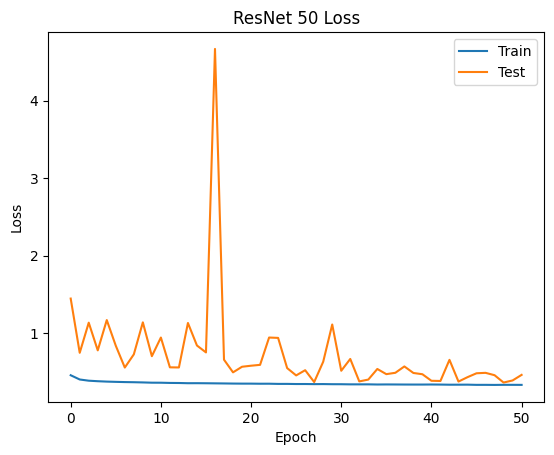

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("ResNet 50 Loss")
plt.ylabel("Loss")
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

## Resnet50: attractive

In [24]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1_l2

from keras.applications import ResNet50
from tensorflow.keras.metrics import Precision, Recall

attr = pd.read_csv('list_attr_celeba.csv')
features = ['image_id', 'Attractive', 'Bangs', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair', 'Male', 'Oval_Face', 'Receding_Hairline', 'Smiling']

attr_selected = attr.loc[:, features].iloc[:50000,:]
attr_selected = attr_selected.replace(-1,0)
features = ['image_id', 'Attractive']

attr_selected = attr.loc[:, features].iloc[:50000,:]
attr_selected = attr_selected.replace(-1,0)

features = ['Attractive']

train_df, test_df = train_test_split(attr_selected, test_size=0.1)
train_df, val_df = train_test_split(train_df, test_size=0.2)

for feature in features:
    train_df[feature] = train_df[feature].astype('float32')
    val_df[feature] = val_df[feature].astype('float32')
    test_df[feature] = test_df[feature].astype('float32')

In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Create ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, zoom_range=0.2, shear_range=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 64
img_height = 128
img_width = 128

train_generator = train_datagen.flow_from_dataframe(train_df, directory="img_align_celeba/img_align_celeba", 
                                                    x_col="image_id", y_col=features,
                                                    target_size=(img_height, img_width), 
                                                    batch_size=batch_size, class_mode='raw')

val_generator = train_datagen.flow_from_dataframe(val_df, directory="img_align_celeba/img_align_celeba", 
                                                    x_col="image_id", y_col=features,
                                                    target_size=(img_height, img_width), 
                                                    batch_size=batch_size, class_mode='raw')

test_generator = test_datagen.flow_from_dataframe(test_df, directory="img_align_celeba/img_align_celeba", 
                                                  x_col="image_id", y_col=features, 
                                                  target_size=(img_height, img_width), 
                                                  batch_size=batch_size, class_mode='raw', shuffle=False)

Found 36000 validated image filenames.
Found 9000 validated image filenames.
Found 5000 validated image filenames.


In [26]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Create new models with the frozen base models and new top layers
def _create_model(input_shape):
    i = 0
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128,128,3))

    for layer in base_model.layers:
        if i <= 160:
            layer.trainable = False
        i+=1
        
    transfer_model = Sequential()
    transfer_model.add(base_model)
    transfer_model.add(Flatten())
    transfer_model.add(Dense(1024, activation='relu'))
    transfer_model.add(BatchNormalization())
    transfer_model.add(Dropout(0.25))
    transfer_model.add(Dense(len(features), activation='sigmoid'))
    return transfer_model

# Earlystop
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

resnet_attractive = _create_model((img_height, img_width))
resnet_attractive.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
history = resnet_attractive.fit(train_generator, epochs = 100, validation_data = val_generator, callbacks = [callback])
loss, accuracy = resnet_attractive.evaluate(test_generator, steps = len(test_generator), verbose = 0)

print("Test Loss:", loss)
print("Test Acc:", accuracy)

94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/100


2023-05-28 04:01:20.930566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-28 04:01:22.922274: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x560b9b6ab500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-28 04:01:22.922290: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-05-28 04:01:22.941259: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-28 04:01:23.053971: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directo

563/563 [==============================] - ETA: 0s - loss: 0.6441 - accuracy: 0.6671

2023-05-28 04:02:12.864767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


563/563 [==============================] - 65s 109ms/step - loss: 0.6441 - accuracy: 0.6671 - val_loss: 0.7509 - val_accuracy: 0.6383
Epoch 2/100
563/563 [==============================] - 60s 106ms/step - loss: 0.5836 - accuracy: 0.6966 - val_loss: 0.6960 - val_accuracy: 0.6114
Epoch 3/100
563/563 [==============================] - 60s 106ms/step - loss: 0.5654 - accuracy: 0.7143 - val_loss: 3.4166 - val_accuracy: 0.4843
Epoch 4/100
563/563 [==============================] - 60s 107ms/step - loss: 0.5574 - accuracy: 0.7202 - val_loss: 0.6588 - val_accuracy: 0.6302
Epoch 5/100
563/563 [==============================] - 60s 106ms/step - loss: 0.5504 - accuracy: 0.7210 - val_loss: 0.8688 - val_accuracy: 0.5544
Epoch 6/100
563/563 [==============================] - 60s 107ms/step - loss: 0.5444 - accuracy: 0.7283 - val_loss: 0.9190 - val_accuracy: 0.5728
Epoch 7/100
563/563 [==============================] - 61s 108ms/step - loss: 0.5425 - accuracy: 0.7311 - val_loss: 0.5472 - val_accurac

2023-05-28 04:46:32.644867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Test Loss: 0.6265203952789307
Test Acc: 0.6990000009536743


In [27]:
resnet_attractive.save('resnet_attractive.h5')

## Resnet: bangs

In [28]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1_l2

from keras.applications import ResNet50
from tensorflow.keras.metrics import Precision, Recall


attr = pd.read_csv('list_attr_celeba.csv')
features = ['image_id', 'Bangs']

attr_selected = attr.loc[:, features].iloc[:50000,:]
attr_selected = attr_selected.replace(-1,0)

features = ['Bangs']

train_df, test_df = train_test_split(attr_selected, test_size=0.1)
train_df, val_df = train_test_split(train_df, test_size=0.2)

for feature in features:
    train_df[feature] = train_df[feature].astype('float32')
    val_df[feature] = val_df[feature].astype('float32')
    test_df[feature] = test_df[feature].astype('float32')

In [29]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Create ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, zoom_range=0.2, shear_range=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 64
img_height = 128
img_width = 128

train_generator = train_datagen.flow_from_dataframe(train_df, directory="img_align_celeba/img_align_celeba", 
                                                    x_col="image_id", y_col=features,
                                                    target_size=(img_height, img_width), 
                                                    batch_size=batch_size, class_mode='raw')

val_generator = train_datagen.flow_from_dataframe(val_df, directory="img_align_celeba/img_align_celeba", 
                                                    x_col="image_id", y_col=features,
                                                    target_size=(img_height, img_width), 
                                                    batch_size=batch_size, class_mode='raw')

test_generator = test_datagen.flow_from_dataframe(test_df, directory="img_align_celeba/img_align_celeba", 
                                                  x_col="image_id", y_col=features, 
                                                  target_size=(img_height, img_width), 
                                                  batch_size=batch_size, class_mode='raw', shuffle=False)

Found 36000 validated image filenames.
Found 9000 validated image filenames.
Found 5000 validated image filenames.


In [30]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Create new models with the frozen base models and new top layers
def _create_model(input_shape):
    i = 0
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128,128,3))

    for layer in base_model.layers:
        if i <= 160:
            layer.trainable = False
        i+=1
        
    transfer_model = Sequential()
    transfer_model.add(base_model)
    transfer_model.add(Flatten())
    transfer_model.add(Dense(1024, activation='relu'))
    transfer_model.add(BatchNormalization())
    transfer_model.add(Dropout(0.25))
    transfer_model.add(Dense(len(features), activation='sigmoid'))
    return transfer_model

# Earlystop
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

resnet_bangs = _create_model((img_height, img_width))
resnet_bangs.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
history = resnet_bangs.fit(train_generator, epochs = 100, validation_data = val_generator, callbacks = [callback])
loss, accuracy = resnet_bangs.evaluate(test_generator, steps = len(test_generator), verbose = 0)

print("Test Loss:", loss)
print("Test Acc:", accuracy)

Epoch 1/100


2023-05-28 04:46:42.598782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


563/563 [==============================] - ETA: 0s - loss: 0.4156 - accuracy: 0.8386

2023-05-28 04:47:33.527922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


563/563 [==============================] - 63s 108ms/step - loss: 0.4156 - accuracy: 0.8386 - val_loss: 0.3919 - val_accuracy: 0.8317
Epoch 2/100
563/563 [==============================] - 60s 107ms/step - loss: 0.3236 - accuracy: 0.8683 - val_loss: 0.3742 - val_accuracy: 0.8557
Epoch 3/100
563/563 [==============================] - 60s 107ms/step - loss: 0.2910 - accuracy: 0.8808 - val_loss: 1.8404 - val_accuracy: 0.2930
Epoch 4/100
563/563 [==============================] - 60s 107ms/step - loss: 0.2718 - accuracy: 0.8889 - val_loss: 0.4387 - val_accuracy: 0.8006
Epoch 5/100
563/563 [==============================] - 60s 106ms/step - loss: 0.2615 - accuracy: 0.8939 - val_loss: 1.1608 - val_accuracy: 0.8380
Epoch 6/100
563/563 [==============================] - 60s 106ms/step - loss: 0.2543 - accuracy: 0.8976 - val_loss: 1.5780 - val_accuracy: 0.3221
Epoch 7/100
563/563 [==============================] - 60s 107ms/step - loss: 0.2496 - accuracy: 0.8986 - val_loss: 0.2971 - val_accurac

2023-05-28 05:23:55.841642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Test Loss: 0.2053508758544922
Test Acc: 0.9186000227928162


In [31]:
resnet_bangs.save('resnet_bangs.h5')